In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import f1_score, confusion_matrix

In [127]:
os.getcwd()

'/home/linuxubuntu/Desktop/usman/Assignment 5'

### Loading Data

In [3]:
path = './Assignment 5 Dataset/'
os.listdir(path)

['train', 'validation', 'test']

In [4]:
train_path = path + 'train'
val_path = path + 'validation'
test_path = path + 'test'

In [21]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
val_data = datasets.ImageFolder(val_path, transform=test_transforms)
test_data = datasets.ImageFolder(test_path, transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


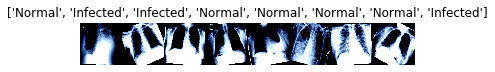

In [6]:
class_names = {0: 'Normal', 1: 'Infected'}
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    classes = classes.numpy()
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

### VGG-16

In [158]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

num_features = vgg16.classifier[0].in_features

for param in vgg16.parameters():         # Freeze all conv layers
    param.requires_grad = False

roll_no = 1
num_classes = 2

features = [nn.Linear(num_features, roll_no*10+100), 
            nn.ReLU(inplace=True), 
            nn.Dropout(p=0.5, inplace=False), 
            nn.Linear(roll_no*10+100, num_classes)]
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Check Requires Grad 

In [143]:
for name, param in vgg16.named_parameters():
    if param.requires_grad:
        print(name)

classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


## Loss Function, Optimizer, Training and Testing

In [144]:
BATCH_SIZE = 8
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [145]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [77]:
def collect_predictions(model, dataloader, device, return_true_labels=True):
    predictions = torch.zeros(len(dataloader.dataset)
                             , requires_grad=False)
    y_true = torch.zeros(len(dataloader.dataset)
                         , requires_grad=False)
    batch_size = dataloader.batch_size
    model.eval()    
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        predictions[i*batch_size:
                (i+1)*batch_size] = torch.argmax(
                                        model(inputs),
                                        axis=1)
        y_true[i*batch_size:
                (i+1)*batch_size] = labels
    if return_true_labels:
        return predictions.detach().numpy(), y_true.detach().numpy()
    else:
        return predictions.numpy()


def accuracy(model, dataloader, device):
    model.eval()    
    correct_predictions = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        outputs = torch.argmax(model(inputs), axis=1)             #----> forward pass
        correct_predictions += (outputs == labels).sum().item()   #----> compute loss

    acc = (correct_predictions/len(dataloader.dataset))*100.
    return acc


def accuracy_and_loss(model, dataloader, critertion, device):
    model.eval()    
    correct_predictions = 0
    loss = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        outputs = model(inputs)             #----> forward pass
        correct_predictions += (torch.argmax(outputs, axis=1) \
                                == labels).sum().item()   #----> compute loss
        loss += criterion(outputs, labels).item()

    acc = (correct_predictions/len(dataloader.dataset))*100.
    mean_loss = (loss/len(dataloader.dataset))*BATCH_SIZE
    return acc, mean_loss


def train(model, dataloader, critertion, optimizer, device, epoch):
    running_loss = 0.0
    model.train()    
    for i, data in enumerate(dataloader):    # train loop 
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        if i%50 == 0:
          print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(dataloader.dataset),
                  loss.item())) 
    return (running_loss/len(dataloader.dataset))*BATCH_SIZE

In [109]:
## Plotting functions

def sample_rgb():
    return (np.random.rand(),np.random.rand(),np.random.rand())

def line_plot(y, 
              x=None, 
              labels=None, 
              title=None, 
              xlabel=None, 
              ylabel=None,
              xlim=None,
              ylim=None,
              ax=None):
    """
    Args:
        y: List of numpy arrays
        x: Optional. Single list or numpy array for x-axis
        legend_labels: Optional. List of strings of same 
                        length as y. 
        title: Optional. Str. Figure Title.
        ax: Optional. Plots to this axis.
    """
    if ax is None:
        fig, ax = plt.subplots()

    if x is None:
        x = [np.arange(np.size(arr)) for arr in y]
    else:
        x_old = x.copy()
        x = [x_old for _ in range(len(y))]
    
    if labels is None:
        labels = [None]*len(y)
        
    for i, arr in enumerate(zip(x,y)):
        ax.plot(arr[0], 
                 arr[1], 
                 color=sample_rgb(), 
                 marker='o', 
                 linestyle='-',
                 linewidth=2,
                 markersize=12,
                 label=labels[i])
    
    plt.legend()
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    
    if ylabel is not None:
        ax.set_ylabel(ylabel)
        
    if title is not None:
        ax.set_title(title)
    
    if xlim is not None:
        ax.set_xlim(xlim)
        
    if ylim is not None:
        ax.set_ylim(ylim)
    
    plt.show()
    
def plot_good_images(good_images):
    inp1 = good_images[0]
    inp2 = good_images[1]
    inp1 = inp1.numpy().transpose((1, 2, 0))
    inp2 = inp2.numpy().transpose((1, 2, 0))
    
    fig, ax = plt.subplots(1,2)
    plt.axis('off')
    ax[0].imshow(inp1)
    ax[1].imshow(inp2)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title('Normal classified as normal.')
    ax[1].set_title('Infected classified as infected.')

def plot_bad_images(bad_images):
    inp1 = bad_images[0]
    inp2 = bad_images[1]
    inp1 = inp1.numpy().transpose((1, 2, 0))
    inp2 = inp2.numpy().transpose((1, 2, 0))
    
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(inp1)
    ax[1].imshow(inp2)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title('Normal classified as infected.')
    ax[1].set_title('Infected classified as normal.')

In [24]:
%%time
# Checking test accuracy
accuracy(vgg16, testloader, device)

CPU times: user 8min 18s, sys: 39.1 s, total: 8min 57s
Wall time: 1min 31s


86.14627285513362

In [146]:
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

# Prior to training check loss and accuracy on train and val sets
train_acc, train_loss = accuracy_and_loss(vgg16, trainloader, criterion, device)
val_acc, val_loss = accuracy_and_loss(vgg16, valloader, criterion, device)

print("Training Loss: {:.4f}\t \
       Training Accuracy: {:.2f}\t \
       Validation Loss: {:.4f}\t \
       Validation Accuracy: {:.2f}\t".format(train_loss, 
                                            train_acc, 
                                            val_loss, 
                                            val_acc))

train_loss_arr.append(train_loss)
train_acc_arr.append(train_acc)
val_loss_arr.append(val_loss)
val_acc_arr.append(val_acc)

for epoch in range(Epochs):  # loop over the dataset multiple times
    train_loss = train(vgg16, trainloader, criterion, optimizer, device, epoch)
    train_acc = accuracy(vgg16, trainloader, device)
    val_acc, val_loss = accuracy_and_loss(vgg16, valloader, criterion, device)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    if val_acc_arr[-1] > val_acc_arr[-2]:
                torch.save(vgg16.state_dict(), './task1/vgg16_FC_Only.pth')

np.save('./task1/train_acc_arr.npy',np.array(train_acc_arr))
np.save('./task1/train_loss_arr.npy',np.array(train_loss_arr))
np.save('./task1/val_acc_arr.npy',np.array(val_acc_arr))
np.save('./task1/val_loss_arr.npy',np.array(val_loss_arr))

Training Loss: 0.7055	        Training Accuracy: 46.50	        Validation Loss: 0.7052	        Validation Accuracy: 45.13	
Train Epoch: 0 [0/2200]	Loss: 0.747069
Train Epoch: 0 [400/2200]	Loss: 0.238603
Train Epoch: 0 [800/2200]	Loss: 0.300073
Train Epoch: 0 [1200/2200]	Loss: 0.245089
Train Epoch: 0 [1600/2200]	Loss: 0.338729
Train Epoch: 0 [2000/2200]	Loss: 0.289616
Epoch  0 	            Training Loss: 0.4455	            Training Accuracy: 82.27	            Validation Loss: 0.4584	            Validation Accuracy: 79.80	
Train Epoch: 1 [0/2200]	Loss: 0.496917
Train Epoch: 1 [400/2200]	Loss: 0.484994
Train Epoch: 1 [800/2200]	Loss: 0.237952
Train Epoch: 1 [1200/2200]	Loss: 0.533357
Train Epoch: 1 [1600/2200]	Loss: 0.127491
Train Epoch: 1 [2000/2200]	Loss: 0.173413
Epoch  1 	            Training Loss: 0.3903	            Training Accuracy: 87.59	            Validation Loss: 0.3783	            Validation Accuracy: 83.73	
Train Epoch: 2 [0/2200]	Loss: 0.555576
Train Epoch: 2 [400/2200]	Loss

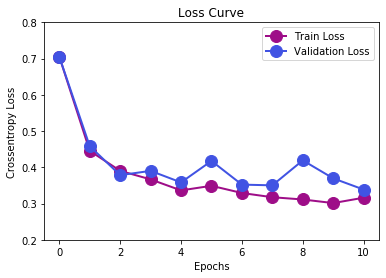

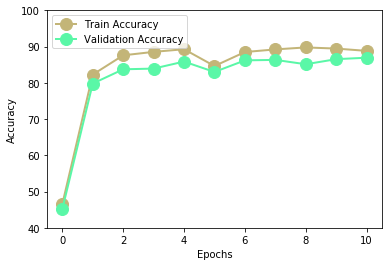

Test Accuracy 92.9676511954993


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test F1 Score 0.9405469678953626
Confusion Matrix For Train
[[ 911  205]
 [  54 1030]]
Confusion Matrix For Validation
[[506 109]
 [ 87 798]]
Confusion Matrix For Test
[[531  84]
 [ 16 791]]


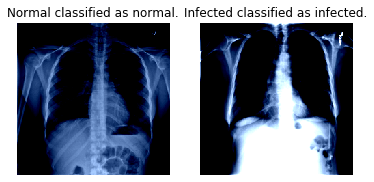

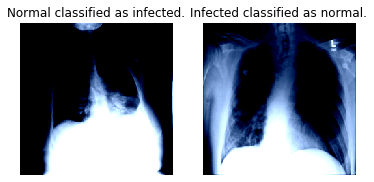

In [148]:
# Plotting
line_plot([np.array(train_loss_arr), 
           np.array(val_loss_arr)], 
          x = np.arange(11),
          labels=['Train Loss',
                  'Validation Loss'],
          ylabel='Crossentropy Loss',
          xlabel='Epochs',
          ylim=[0.2,0.8],
          title='Loss Curve')

line_plot([np.array(train_acc_arr), 
           np.array(val_acc_arr)], 
          x = np.arange(11),
          labels=['Train Accuracy',
                  'Validation Accuracy'],
          ylabel='Accuracy',
          xlabel='Epochs',
          ylim=[40,100],
          title=None)

print("Test Accuracy", accuracy(vgg16, testloader, device))
y_pred_train, y_true_train = collect_predictions(vgg16, trainloader, device)
y_pred_val, y_true_val = collect_predictions(vgg16, valloader, device)
y_pred_test, y_true_test = collect_predictions(vgg16, testloader, device)
print("Test F1 Score", f1_score(y_true_test, y_pred_test))
print("Confusion Matrix For Train")
print(confusion_matrix(y_true_train, y_pred_train))
print("Confusion Matrix For Validation")
print(confusion_matrix(y_true_val, y_pred_val))
print("Confusion Matrix For Test")
print(confusion_matrix(y_true_test, y_pred_test))

import random
good_images_idx = [
random.choice(np.where((y_pred_test == (y_true_test == 0)) == True)[0].tolist()),
random.choice(np.where((y_pred_test == (y_true_test == 1)) == True)[0].tolist())
]

bad_images_idx = [
random.choice(np.where((y_pred_test != (y_true_test == 0)) == True)[0].tolist()),
random.choice(np.where((y_pred_test != (y_true_test == 1)) == True)[0].tolist())
]

good_images = []
bad_images = []
for idx1, idx2 in zip(good_images_idx, bad_images_idx):
    good_images.append(testloader.dataset[idx1][0])
    bad_images.append(testloader.dataset[idx2][0])
    
plot_good_images(good_images)
plot_bad_images(bad_images)

### Task 2a: Freeze all conv layers except last one

In [154]:
for param in vgg16.features[28].parameters():
    param.requires_grad = True
    
for name, param in vgg16.named_parameters():
    if param.requires_grad:
        print(name)
        
BATCH_SIZE = 8
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [155]:
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

# Prior to training check loss and accuracy on train and val sets
train_acc, train_loss = accuracy_and_loss(vgg16, trainloader, criterion, device)
val_acc, val_loss = accuracy_and_loss(vgg16, valloader, criterion, device)

print("Training Loss: {:.4f}\t \
       Training Accuracy: {:.2f}\t \
       Validation Loss: {:.4f}\t \
       Validation Accuracy: {:.2f}\t".format(train_loss, 
                                            train_acc, 
                                            val_loss, 
                                            val_acc))

train_loss_arr.append(train_loss)
train_acc_arr.append(train_acc)
val_loss_arr.append(val_loss)
val_acc_arr.append(val_acc)

for epoch in range(Epochs):  # loop over the dataset multiple times
    train_loss = train(vgg16, trainloader, criterion, optimizer, device, epoch)
    train_acc = accuracy(vgg16, trainloader, device)
    val_acc, val_loss = accuracy_and_loss(vgg16, valloader, criterion, device)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    if val_acc_arr[-1] > val_acc_arr[-2]:
                torch.save(vgg16.state_dict(), './task2a/vgg16_FC_Only.pth')

np.save('./task2a/train_acc_arr.npy',np.array(train_acc_arr))
np.save('./task2a/train_loss_arr.npy',np.array(train_loss_arr))
np.save('./task2a/val_acc_arr.npy',np.array(val_acc_arr))
np.save('./task2a/val_loss_arr.npy',np.array(val_loss_arr))

Training Loss: 0.7085	        Training Accuracy: 44.50	        Validation Loss: 0.7127	        Validation Accuracy: 42.33	
Train Epoch: 0 [0/2200]	Loss: 0.752378
Train Epoch: 0 [400/2200]	Loss: 0.367366
Train Epoch: 0 [800/2200]	Loss: 0.237732
Train Epoch: 0 [1200/2200]	Loss: 0.004635
Train Epoch: 0 [1600/2200]	Loss: 0.113052
Train Epoch: 0 [2000/2200]	Loss: 0.245685
Epoch  0 	            Training Loss: 0.4092	            Training Accuracy: 86.55	            Validation Loss: 0.4175	            Validation Accuracy: 81.73	
Train Epoch: 1 [0/2200]	Loss: 0.235119
Train Epoch: 1 [400/2200]	Loss: 0.317354
Train Epoch: 1 [800/2200]	Loss: 1.541389
Train Epoch: 1 [1200/2200]	Loss: 0.477335
Train Epoch: 1 [1600/2200]	Loss: 0.415235
Train Epoch: 1 [2000/2200]	Loss: 0.852302
Epoch  1 	            Training Loss: 0.2929	            Training Accuracy: 92.09	            Validation Loss: 0.3477	            Validation Accuracy: 87.27	
Train Epoch: 2 [0/2200]	Loss: 0.307348
Train Epoch: 2 [400/2200]	Loss

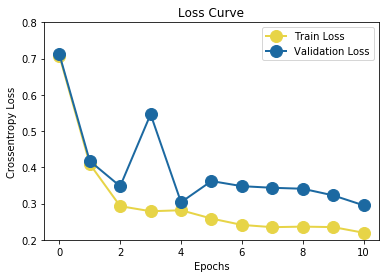

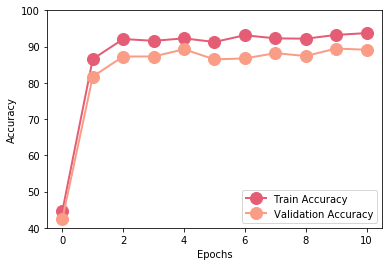

Test Accuracy 94.79606188466948


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test F1 Score 0.9547123623011016
Confusion Matrix For Train
[[1024   92]
 [  50 1034]]
Confusion Matrix For Validation
[[536  79]
 [ 84 801]]
Confusion Matrix For Test
[[568  47]
 [ 27 780]]


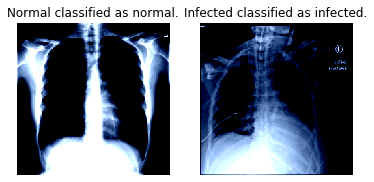

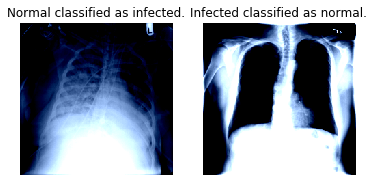

In [157]:
# Plotting
line_plot([np.array(train_loss_arr), 
           np.array(val_loss_arr)], 
          x = np.arange(11),
          labels=['Train Loss',
                  'Validation Loss'],
          ylabel='Crossentropy Loss',
          xlabel='Epochs',
          ylim=[0.2,0.8],
          title='Loss Curve')

line_plot([np.array(train_acc_arr), 
           np.array(val_acc_arr)], 
          x = np.arange(11),
          labels=['Train Accuracy',
                  'Validation Accuracy'],
          ylabel='Accuracy',
          xlabel='Epochs',
          ylim=[40,100],
          title=None)

print("Test Accuracy", accuracy(vgg16, testloader, device))
y_pred_train, y_true_train = collect_predictions(vgg16, trainloader, device)
y_pred_val, y_true_val = collect_predictions(vgg16, valloader, device)
y_pred_test, y_true_test = collect_predictions(vgg16, testloader, device)
print("Test F1 Score", f1_score(y_true_test, y_pred_test))
print("Confusion Matrix For Train")
print(confusion_matrix(y_true_train, y_pred_train))
print("Confusion Matrix For Validation")
print(confusion_matrix(y_true_val, y_pred_val))
print("Confusion Matrix For Test")
print(confusion_matrix(y_true_test, y_pred_test))

import random
good_images_idx = [
random.choice(np.where((y_pred_test == (y_true_test == 0)) == True)[0].tolist()),
random.choice(np.where((y_pred_test == (y_true_test == 1)) == True)[0].tolist())
]

bad_images_idx = [
random.choice(np.where((y_pred_test != (y_true_test == 0)) == True)[0].tolist()),
random.choice(np.where((y_pred_test != (y_true_test == 1)) == True)[0].tolist())
]

good_images = []
bad_images = []
for idx1, idx2 in zip(good_images_idx, bad_images_idx):
    good_images.append(testloader.dataset[idx1][0])
    bad_images.append(testloader.dataset[idx2][0])
    
plot_good_images(good_images)
plot_bad_images(bad_images)

### Task 2b: No Freezing of weights

In [160]:
for param in vgg16.parameters():
    param.requires_grad = True
    
for name, param in vgg16.named_parameters():
    if param.requires_grad:
        print(name)
        
BATCH_SIZE = 8
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [161]:
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

# Prior to training check loss and accuracy on train and val sets
train_acc, train_loss = accuracy_and_loss(vgg16, trainloader, criterion, device)
val_acc, val_loss = accuracy_and_loss(vgg16, valloader, criterion, device)

print("Training Loss: {:.4f}\t \
       Training Accuracy: {:.2f}\t \
       Validation Loss: {:.4f}\t \
       Validation Accuracy: {:.2f}\t".format(train_loss, 
                                            train_acc, 
                                            val_loss, 
                                            val_acc))

train_loss_arr.append(train_loss)
train_acc_arr.append(train_acc)
val_loss_arr.append(val_loss)
val_acc_arr.append(val_acc)

for epoch in range(Epochs):  # loop over the dataset multiple times
    train_loss = train(vgg16, trainloader, criterion, optimizer, device, epoch)
    train_acc = accuracy(vgg16, trainloader, device)
    val_acc, val_loss = accuracy_and_loss(vgg16, valloader, criterion, device)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    if val_acc_arr[-1] > val_acc_arr[-2]:
                torch.save(vgg16.state_dict(), './task2b/vgg16_FC_Only.pth')

np.save('./task2b/vgg16_train_acc_arr.npy',np.array(train_acc_arr))
np.save('./task2b/vgg16_train_loss_arr.npy',np.array(train_loss_arr))
np.save('./task2b/vgg16_val_acc_arr.npy',np.array(val_acc_arr))
np.save('./task2b/vgg16_val_loss_arr.npy',np.array(val_loss_arr))

Training Loss: 0.7175	        Training Accuracy: 49.86	        Validation Loss: 0.7336	        Validation Accuracy: 41.13	
Train Epoch: 0 [0/2200]	Loss: 0.778982
Train Epoch: 0 [400/2200]	Loss: 0.330974
Train Epoch: 0 [800/2200]	Loss: 0.540422
Train Epoch: 0 [1200/2200]	Loss: 0.139553
Train Epoch: 0 [1600/2200]	Loss: 0.550888
Train Epoch: 0 [2000/2200]	Loss: 0.236236
Epoch  0 	            Training Loss: 0.4029	            Training Accuracy: 89.55	            Validation Loss: 0.3921	            Validation Accuracy: 86.00	
Train Epoch: 1 [0/2200]	Loss: 0.112499
Train Epoch: 1 [400/2200]	Loss: 0.530246
Train Epoch: 1 [800/2200]	Loss: 0.217602
Train Epoch: 1 [1200/2200]	Loss: 0.195215
Train Epoch: 1 [1600/2200]	Loss: 0.454077
Train Epoch: 1 [2000/2200]	Loss: 0.225241
Epoch  1 	            Training Loss: 0.3049	            Training Accuracy: 90.59	            Validation Loss: 0.2972	            Validation Accuracy: 88.67	
Train Epoch: 2 [0/2200]	Loss: 0.128578
Train Epoch: 2 [400/2200]	Loss

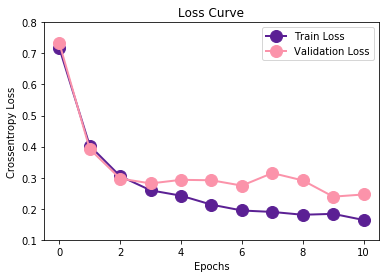

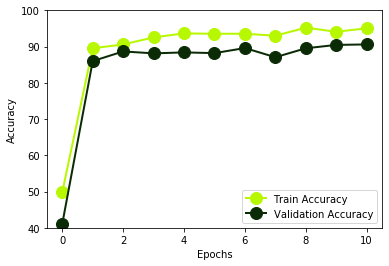

Test Accuracy 96.48382559774966
Test F1 Score 0.9695493300852618
Confusion Matrix For Train
[[1024   92]
 [  22 1062]]
Confusion Matrix For Validation
[[532  83]
 [ 58 827]]
Confusion Matrix For Test
[[576  39]
 [ 11 796]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


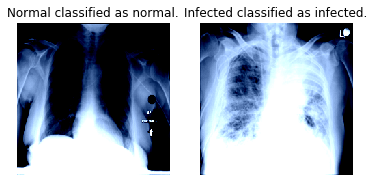

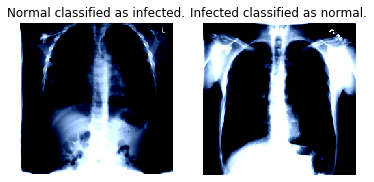

In [162]:
# Plotting
line_plot([np.array(train_loss_arr), 
           np.array(val_loss_arr)], 
          x = np.arange(11),
          labels=['Train Loss',
                  'Validation Loss'],
          ylabel='Crossentropy Loss',
          xlabel='Epochs',
          ylim=[0.1,0.8],
          title='Loss Curve')

line_plot([np.array(train_acc_arr), 
           np.array(val_acc_arr)], 
          x = np.arange(11),
          labels=['Train Accuracy',
                  'Validation Accuracy'],
          ylabel='Accuracy',
          xlabel='Epochs',
          ylim=[40,100],
          title=None)

print("Test Accuracy", accuracy(vgg16, testloader, device))
y_pred_train, y_true_train = collect_predictions(vgg16, trainloader, device)
y_pred_val, y_true_val = collect_predictions(vgg16, valloader, device)
y_pred_test, y_true_test = collect_predictions(vgg16, testloader, device)
print("Test F1 Score", f1_score(y_true_test, y_pred_test))
print("Confusion Matrix For Train")
print(confusion_matrix(y_true_train, y_pred_train))
print("Confusion Matrix For Validation")
print(confusion_matrix(y_true_val, y_pred_val))
print("Confusion Matrix For Test")
print(confusion_matrix(y_true_test, y_pred_test))

import random
good_images_idx = [
random.choice(np.where((y_pred_test == (y_true_test == 0)) == True)[0].tolist()),
random.choice(np.where((y_pred_test == (y_true_test == 1)) == True)[0].tolist())
]

bad_images_idx = [
random.choice(np.where((y_pred_test != (y_true_test == 0)) == True)[0].tolist()),
random.choice(np.where((y_pred_test != (y_true_test == 1)) == True)[0].tolist())
]

good_images = []
bad_images = []
for idx1, idx2 in zip(good_images_idx, bad_images_idx):
    good_images.append(testloader.dataset[idx1][0])
    bad_images.append(testloader.dataset[idx2][0])
    
plot_good_images(good_images)
plot_bad_images(bad_images)

## Res Net 18

In [7]:
resnet18 = models.resnet18(pretrained=True)

for param in resnet18.parameters():         # Freeze all conv layers
    param.requires_grad = False

resnet18

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/linuxubuntu/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
resnet18.fc 

Linear(in_features=512, out_features=1000, bias=True)

In [10]:
## Freeze all weights except FC
num_features = resnet18.fc.in_features

roll_no = 1
num_classes = 2

features = [nn.Linear(num_features, roll_no*10+100), 
            nn.ReLU(inplace=True), 
            nn.Linear(roll_no*10+100, num_classes)]
resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name)

fc.0.weight
fc.0.bias
fc.2.weight
fc.2.bias


In [23]:
BATCH_SIZE = 8
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

# Prior to training check loss and accuracy on train and val sets
train_acc, train_loss = accuracy_and_loss(resnet18, trainloader, criterion, device)
val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device)

print("Training Loss: {:.4f}\t \
       Training Accuracy: {:.2f}\t \
       Validation Loss: {:.4f}\t \
       Validation Accuracy: {:.2f}\t".format(train_loss, 
                                            train_acc, 
                                            val_loss, 
                                            val_acc))

train_loss_arr.append(train_loss)
train_acc_arr.append(train_acc)
val_loss_arr.append(val_loss)
val_acc_arr.append(val_acc)

for epoch in range(Epochs):  # loop over the dataset multiple times
    train_loss = train(resnet18, trainloader, criterion, optimizer, device, epoch)
    train_acc = accuracy(resnet18, trainloader, device)
    val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    if val_acc_arr[-1] > val_acc_arr[-2]:
                torch.save(resnet18.state_dict(), './task1/resnet18_FC_Only.pth')

np.save('./task1/resnet18_train_acc_arr.npy',np.array(train_acc_arr))
np.save('./task1/resnet18_train_loss_arr.npy',np.array(train_loss_arr))
np.save('./task1/resnet18_val_acc_arr.npy',np.array(val_acc_arr))
np.save('./task1/resnet18_val_loss_arr.npy',np.array(val_loss_arr))

Training Loss: 0.7771	        Training Accuracy: 49.27	        Validation Loss: 0.6785	        Validation Accuracy: 59.00	
Train Epoch: 0 [0/2200]	Loss: 0.617028
Train Epoch: 0 [400/2200]	Loss: 0.357758
Train Epoch: 0 [800/2200]	Loss: 0.490074
Train Epoch: 0 [1200/2200]	Loss: 1.028391
Train Epoch: 0 [1600/2200]	Loss: 0.654988
Train Epoch: 0 [2000/2200]	Loss: 0.406394
Epoch  0 	            Training Loss: 0.4898	            Training Accuracy: 84.55	            Validation Loss: 0.4570	            Validation Accuracy: 80.07	
Train Epoch: 1 [0/2200]	Loss: 0.764388
Train Epoch: 1 [400/2200]	Loss: 0.363045
Train Epoch: 1 [800/2200]	Loss: 0.705975
Train Epoch: 1 [1200/2200]	Loss: 0.351866
Train Epoch: 1 [1600/2200]	Loss: 0.415469
Train Epoch: 1 [2000/2200]	Loss: 0.367148
Epoch  1 	            Training Loss: 0.4301	            Training Accuracy: 85.50	            Validation Loss: 0.3617	            Validation Accuracy: 84.73	
Train Epoch: 2 [0/2200]	Loss: 0.395825
Train Epoch: 2 [400/2200]	Loss

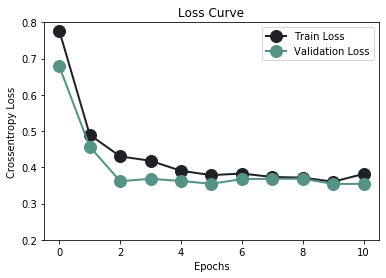

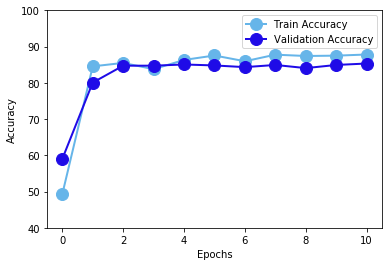

In [60]:
# Plotting
line_plot([np.array(train_loss_arr), 
           np.array(val_loss_arr)], 
          x = np.arange(11),
          labels=['Train Loss',
                  'Validation Loss'],
          ylabel='Crossentropy Loss',
          xlabel='Epochs',
          ylim=[0.2,0.8],
          title='Loss Curve')

line_plot([np.array(train_acc_arr), 
           np.array(val_acc_arr)], 
          x = np.arange(11),
          labels=['Train Accuracy',
                  'Validation Accuracy'],
          ylabel='Accuracy',
          xlabel='Epochs',
          ylim=[40,100],
          title=None)

In [59]:
print("Test Accuracy", accuracy(resnet18, testloader, device))

91.42053445850914

In [79]:
y_pred_train, y_true_train = collect_predictions(resnet18, trainloader, device)
y_pred_val, y_true_val = collect_predictions(resnet18, valloader, device)
y_pred_test, y_true_test = collect_predictions(resnet18, testloader, device)
print("Test F1 Score", f1_score(y_true_test, y_pred_test))
print("Confusion Matrix For Train")
print(confusion_matrix(y_true_train, y_pred_train))
print("Confusion Matrix For Validation")
print(confusion_matrix(y_true_val, y_pred_val))
print("Confusion Matrix For Test")
print(confusion_matrix(y_true_test, y_pred_test))

Test F1 Score 0.9246913580246912
Confusion Matrix For Train
[[946 170]
 [ 94 990]]
Confusion Matrix For Validation
[[521  94]
 [126 759]]
Confusion Matrix For Test
[[551  64]
 [ 58 749]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


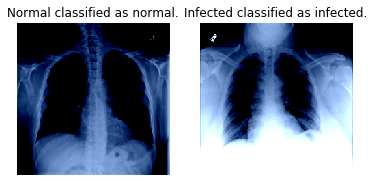

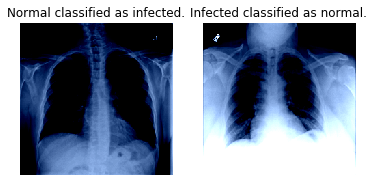

In [110]:
import random
good_images_idx = [
random.choice(np.where((y_pred_test == (y_true_test == 0)) == True)[0].tolist()),
random.choice(np.where((y_pred_test == (y_true_test == 1)) == True)[0].tolist())
]

bad_images_idx = [
random.choice(np.where((y_pred_test != (y_true_test == 0)) == True)[0].tolist()),
random.choice(np.where((y_pred_test != (y_true_test == 1)) == True)[0].tolist())
]

good_images = []
bad_images = []
for idx1, idx2 in zip(good_images_idx, bad_images_idx):
    good_images.append(testloader.dataset[idx1][0])
    bad_images.append(testloader.dataset[idx1][0])
    
plot_good_images(good_images)
plot_bad_images(bad_images)

### Task 2a

In [111]:
# unfreezing last residual block
for param in resnet18.layer4[1].parameters():         # Freeze all conv layers
    param.requires_grad = True

for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name)
        
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.0.weight
fc.0.bias
fc.2.weight
fc.2.bias


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [116]:
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

# Prior to training check loss and accuracy on train and val sets
train_acc, train_loss = accuracy_and_loss(resnet18, trainloader, criterion, device)
val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device)

print("Training Loss: {:.4f}\t \
       Training Accuracy: {:.2f}\t \
       Validation Loss: {:.4f}\t \
       Validation Accuracy: {:.2f}\t".format(train_loss, 
                                            train_acc, 
                                            val_loss, 
                                            val_acc))

train_loss_arr.append(train_loss)
train_acc_arr.append(train_acc)
val_loss_arr.append(val_loss)
val_acc_arr.append(val_acc)

for epoch in range(Epochs):  # loop over the dataset multiple times
    train_loss = train(resnet18, trainloader, criterion, optimizer, device, epoch)
    train_acc = accuracy(resnet18, trainloader, device)
    val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    if val_acc_arr[-1] > val_acc_arr[-2]:
                torch.save(resnet18.state_dict(), './task2a/resnet18_FC_Only.pth')

np.save('./task2a/resnet18_train_acc_arr.npy',np.array(train_acc_arr))
np.save('./task2a/resnet18_train_loss_arr.npy',np.array(train_loss_arr))
np.save('./task2a/resnet18_val_acc_arr.npy',np.array(val_acc_arr))
np.save('./task2a/resnet18_val_loss_arr.npy',np.array(val_loss_arr))

Training Loss: 0.2566	        Training Accuracy: 90.18	        Validation Loss: 0.3341	        Validation Accuracy: 86.33	
Train Epoch: 0 [0/2200]	Loss: 0.079330
Train Epoch: 0 [400/2200]	Loss: 0.108328
Train Epoch: 0 [800/2200]	Loss: 0.631405
Train Epoch: 0 [1200/2200]	Loss: 0.148589
Train Epoch: 0 [1600/2200]	Loss: 0.527974
Train Epoch: 0 [2000/2200]	Loss: 0.157870
Epoch  0 	            Training Loss: 0.3276	            Training Accuracy: 91.09	            Validation Loss: 0.3326	            Validation Accuracy: 87.47	
Train Epoch: 1 [0/2200]	Loss: 0.120881
Train Epoch: 1 [400/2200]	Loss: 0.231191
Train Epoch: 1 [800/2200]	Loss: 0.542708
Train Epoch: 1 [1200/2200]	Loss: 0.380180
Train Epoch: 1 [1600/2200]	Loss: 0.096719
Train Epoch: 1 [2000/2200]	Loss: 0.056065
Epoch  1 	            Training Loss: 0.3090	            Training Accuracy: 92.27	            Validation Loss: 0.5224	            Validation Accuracy: 82.07	
Train Epoch: 2 [0/2200]	Loss: 0.031543
Train Epoch: 2 [400/2200]	Loss

In [117]:
# Prior to training check loss and accuracy on train and val sets
train_acc, train_loss = accuracy_and_loss(resnet18, trainloader, criterion, device)
val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device)

print("Training Loss: {:.4f}\t \
       Training Accuracy: {:.2f}\t \
       Validation Loss: {:.4f}\t \
       Validation Accuracy: {:.2f}\t".format(train_loss, 
                                            train_acc, 
                                            val_loss, 
                                            val_acc))

train_loss_arr.append(train_loss)
train_acc_arr.append(train_acc)
val_loss_arr.append(val_loss)
val_acc_arr.append(val_acc)

for epoch in range(Epochs):  # loop over the dataset multiple times
    train_loss = train(resnet18, trainloader, criterion, optimizer, device, epoch)
    train_acc = accuracy(resnet18, trainloader, device)
    val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch + 10,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    if val_acc_arr[-1] > val_acc_arr[-2]:
                torch.save(resnet18.state_dict(), './task2a/resnet18_FC_Only.pth')

np.save('./task2a/resnet18_train_acc_arr.npy',np.array(train_acc_arr))
np.save('./task2a/resnet18_train_loss_arr.npy',np.array(train_loss_arr))
np.save('./task2a/resnet18_val_acc_arr.npy',np.array(val_acc_arr))
np.save('./task2a/resnet18_val_loss_arr.npy',np.array(val_loss_arr))

Training Loss: 0.1921	        Training Accuracy: 93.82	        Validation Loss: 0.3136	        Validation Accuracy: 87.87	
Train Epoch: 0 [0/2200]	Loss: 0.160654
Train Epoch: 0 [400/2200]	Loss: 0.022754
Train Epoch: 0 [800/2200]	Loss: 0.087207
Train Epoch: 0 [1200/2200]	Loss: 0.112995
Train Epoch: 0 [1600/2200]	Loss: 0.261720
Train Epoch: 0 [2000/2200]	Loss: 0.104516
Epoch 10 	            Training Loss: 0.2370	            Training Accuracy: 93.64	            Validation Loss: 0.3614	            Validation Accuracy: 86.73	
Train Epoch: 1 [0/2200]	Loss: 0.058876
Train Epoch: 1 [400/2200]	Loss: 0.406077
Train Epoch: 1 [800/2200]	Loss: 0.203966
Train Epoch: 1 [1200/2200]	Loss: 0.462190
Train Epoch: 1 [1600/2200]	Loss: 0.494977
Train Epoch: 1 [2000/2200]	Loss: 0.417435
Epoch 11 	            Training Loss: 0.2283	            Training Accuracy: 93.23	            Validation Loss: 0.3239	            Validation Accuracy: 87.87	
Train Epoch: 2 [0/2200]	Loss: 0.161398
Train Epoch: 2 [400/2200]	Loss

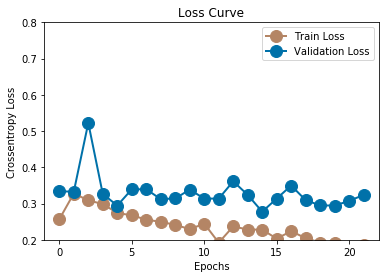

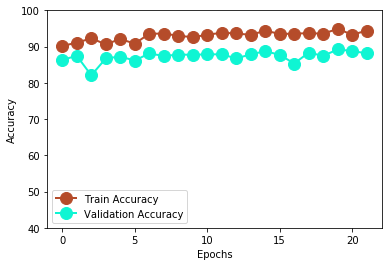

Test Accuracy 94.72573839662446


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test F1 Score 0.9546827794561933
Confusion Matrix For Train
[[1028   88]
 [  21 1063]]
Confusion Matrix For Validation
[[522  93]
 [ 85 800]]
Confusion Matrix For Test
[[557  58]
 [ 17 790]]


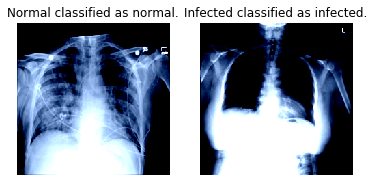

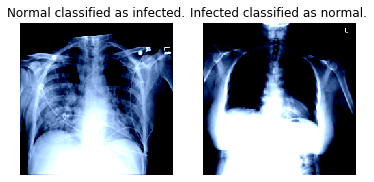

In [120]:
# Plotting
line_plot([np.array(train_loss_arr), 
           np.array(val_loss_arr)], 
          x = np.arange(22),
          labels=['Train Loss',
                  'Validation Loss'],
          ylabel='Crossentropy Loss',
          xlabel='Epochs',
          ylim=[0.2,0.8],
          title='Loss Curve')

line_plot([np.array(train_acc_arr), 
           np.array(val_acc_arr)], 
          x = np.arange(22),
          labels=['Train Accuracy',
                  'Validation Accuracy'],
          ylabel='Accuracy',
          xlabel='Epochs',
          ylim=[40,100],
          title=None)

print("Test Accuracy", accuracy(resnet18, testloader, device))
y_pred_train, y_true_train = collect_predictions(resnet18, trainloader, device)
y_pred_val, y_true_val = collect_predictions(resnet18, valloader, device)
y_pred_test, y_true_test = collect_predictions(resnet18, testloader, device)
print("Test F1 Score", f1_score(y_true_test, y_pred_test))
print("Confusion Matrix For Train")
print(confusion_matrix(y_true_train, y_pred_train))
print("Confusion Matrix For Validation")
print(confusion_matrix(y_true_val, y_pred_val))
print("Confusion Matrix For Test")
print(confusion_matrix(y_true_test, y_pred_test))

import random
good_images_idx = [
random.choice(np.where((y_pred_test == (y_true_test == 0)) == True)[0].tolist()),
random.choice(np.where((y_pred_test == (y_true_test == 1)) == True)[0].tolist())
]

bad_images_idx = [
random.choice(np.where((y_pred_test != (y_true_test == 0)) == True)[0].tolist()),
random.choice(np.where((y_pred_test != (y_true_test == 1)) == True)[0].tolist())
]

good_images = []
bad_images = []
for idx1, idx2 in zip(good_images_idx, bad_images_idx):
    good_images.append(testloader.dataset[idx1][0])
    bad_images.append(testloader.dataset[idx1][0])
    
plot_good_images(good_images)
plot_bad_images(bad_images)

### Task 2b

In [128]:
# unfreezing last residual block
for param in resnet18.parameters():         # Freeze all conv layers
    param.requires_grad = True

for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name)
        
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
print()

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [129]:
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

# Prior to training check loss and accuracy on train and val sets
train_acc, train_loss = accuracy_and_loss(resnet18, trainloader, criterion, device)
val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device)

print("Training Loss: {:.4f}\t \
       Training Accuracy: {:.2f}\t \
       Validation Loss: {:.4f}\t \
       Validation Accuracy: {:.2f}\t".format(train_loss, 
                                            train_acc, 
                                            val_loss, 
                                            val_acc))

train_loss_arr.append(train_loss)
train_acc_arr.append(train_acc)
val_loss_arr.append(val_loss)
val_acc_arr.append(val_acc)

for epoch in range(Epochs):  # loop over the dataset multiple times
    train_loss = train(resnet18, trainloader, criterion, optimizer, device, epoch)
    train_acc = accuracy(resnet18, trainloader, device)
    val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    if val_acc_arr[-1] > val_acc_arr[-2]:
                torch.save(resnet18.state_dict(), './task2b/resnet18_FC_Only.pth')

np.save('./task2b/resnet18_train_acc_arr.npy',np.array(train_acc_arr))
np.save('./task2b/resnet18_train_loss_arr.npy',np.array(train_loss_arr))
np.save('./task2b/resnet18_val_acc_arr.npy',np.array(val_acc_arr))
np.save('./task2b/resnet18_val_loss_arr.npy',np.array(val_loss_arr))

Training Loss: 0.3077	        Training Accuracy: 87.09	        Validation Loss: 0.3439	        Validation Accuracy: 85.13	
Train Epoch: 0 [0/2200]	Loss: 0.191196
Train Epoch: 0 [400/2200]	Loss: 1.017208
Train Epoch: 0 [800/2200]	Loss: 0.142940
Train Epoch: 0 [1200/2200]	Loss: 0.280008
Train Epoch: 0 [1600/2200]	Loss: 1.155491
Train Epoch: 0 [2000/2200]	Loss: 0.510120
Epoch  0 	            Training Loss: 0.3845	            Training Accuracy: 86.32	            Validation Loss: 0.3802	            Validation Accuracy: 82.73	
Train Epoch: 1 [0/2200]	Loss: 0.135077
Train Epoch: 1 [400/2200]	Loss: 0.722008
Train Epoch: 1 [800/2200]	Loss: 0.285009
Train Epoch: 1 [1200/2200]	Loss: 0.100820
Train Epoch: 1 [1600/2200]	Loss: 0.744181
Train Epoch: 1 [2000/2200]	Loss: 0.262095
Epoch  1 	            Training Loss: 0.3226	            Training Accuracy: 85.86	            Validation Loss: 0.4628	            Validation Accuracy: 81.07	
Train Epoch: 2 [0/2200]	Loss: 0.228797
Train Epoch: 2 [400/2200]	Loss

In [133]:
# train_loss_arr = []
# train_acc_arr = []
# val_loss_arr = []
# val_acc_arr = []

# Prior to training check loss and accuracy on train and val sets
train_acc, train_loss = accuracy_and_loss(resnet18, trainloader, criterion, device)
val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device)

print("Training Loss: {:.4f}\t \
       Training Accuracy: {:.2f}\t \
       Validation Loss: {:.4f}\t \
       Validation Accuracy: {:.2f}\t".format(train_loss, 
                                            train_acc, 
                                            val_loss, 
                                            val_acc))

train_loss_arr.append(train_loss)
train_acc_arr.append(train_acc)
val_loss_arr.append(val_loss)
val_acc_arr.append(val_acc)

for epoch in range(5, Epochs+5):  # loop over the dataset multiple times
    train_loss = train(resnet18, trainloader, criterion, optimizer, device, epoch)
    train_acc = accuracy(resnet18, trainloader, device)
    val_acc, val_loss = accuracy_and_loss(resnet18, valloader, criterion, device)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    if val_acc_arr[-1] > val_acc_arr[-2]:
                torch.save(resnet18.state_dict(), './task2b/resnet18_FC_Only.pth')

np.save('./task2b/resnet18_train_acc_arr.npy',np.array(train_acc_arr))
np.save('./task2b/resnet18_train_loss_arr.npy',np.array(train_loss_arr))
np.save('./task2b/resnet18_val_acc_arr.npy',np.array(val_acc_arr))
np.save('./task2b/resnet18_val_loss_arr.npy',np.array(val_loss_arr))

Training Loss: 0.2443	        Training Accuracy: 90.36	        Validation Loss: 0.2968	        Validation Accuracy: 88.13	
Train Epoch: 5 [0/2200]	Loss: 0.124238
Train Epoch: 5 [400/2200]	Loss: 0.183380
Train Epoch: 5 [800/2200]	Loss: 0.479611
Train Epoch: 5 [1200/2200]	Loss: 0.117901
Train Epoch: 5 [1600/2200]	Loss: 0.512841
Train Epoch: 5 [2000/2200]	Loss: 0.100450
Epoch  5 	            Training Loss: 0.2516	            Training Accuracy: 91.86	            Validation Loss: 0.2769	            Validation Accuracy: 89.40	
Train Epoch: 6 [0/2200]	Loss: 0.604789
Train Epoch: 6 [400/2200]	Loss: 0.032801
Train Epoch: 6 [800/2200]	Loss: 0.203864
Train Epoch: 6 [1200/2200]	Loss: 0.100970
Train Epoch: 6 [1600/2200]	Loss: 1.102908
Train Epoch: 6 [2000/2200]	Loss: 0.067934
Epoch  6 	            Training Loss: 0.2478	            Training Accuracy: 90.64	            Validation Loss: 0.3271	            Validation Accuracy: 87.20	
Train Epoch: 7 [0/2200]	Loss: 0.552036
Train Epoch: 7 [400/2200]	Loss

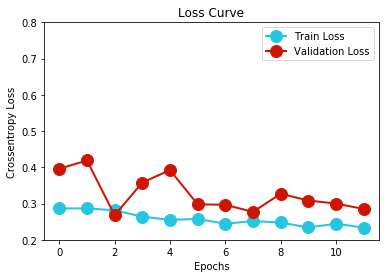

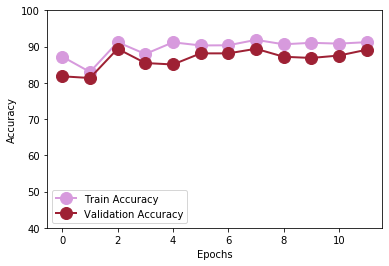

Test Accuracy 94.86638537271449


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test F1 Score 0.9555690809494827
Confusion Matrix For Train
[[ 980  136]
 [  46 1038]]
Confusion Matrix For Validation
[[526  89]
 [ 74 811]]
Confusion Matrix For Test
[[564  51]
 [ 22 785]]


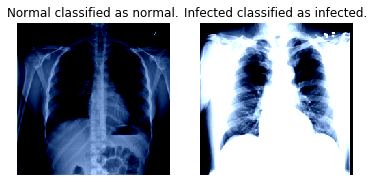

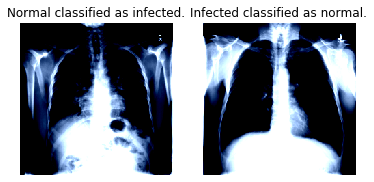

In [141]:
# Plotting
line_plot([np.array(train_loss_arr), 
           np.array(val_loss_arr)], 
          x = np.arange(12),
          labels=['Train Loss',
                  'Validation Loss'],
          ylabel='Crossentropy Loss',
          xlabel='Epochs',
          ylim=[0.2,0.8],
          title='Loss Curve')

line_plot([np.array(train_acc_arr), 
           np.array(val_acc_arr)], 
          x = np.arange(12),
          labels=['Train Accuracy',
                  'Validation Accuracy'],
          ylabel='Accuracy',
          xlabel='Epochs',
          ylim=[40,100],
          title=None)

print("Test Accuracy", accuracy(resnet18, testloader, device))
y_pred_train, y_true_train = collect_predictions(resnet18, trainloader, device)
y_pred_val, y_true_val = collect_predictions(resnet18, valloader, device)
y_pred_test, y_true_test = collect_predictions(resnet18, testloader, device)
print("Test F1 Score", f1_score(y_true_test, y_pred_test))
print("Confusion Matrix For Train")
print(confusion_matrix(y_true_train, y_pred_train))
print("Confusion Matrix For Validation")
print(confusion_matrix(y_true_val, y_pred_val))
print("Confusion Matrix For Test")
print(confusion_matrix(y_true_test, y_pred_test))

good_images_idx = [
random.choice(np.where((y_pred_test == (y_true_test == 0)) == True)[0].tolist()),
random.choice(np.where((y_pred_test == (y_true_test == 1)) == True)[0].tolist())
]

bad_images_idx = [
random.choice(np.where((y_pred_test != (y_true_test == 0)) == True)[0].tolist()),
random.choice(np.where((y_pred_test != (y_true_test == 1)) == True)[0].tolist())
]

good_images = []
bad_images = []
for idx1, idx2 in zip(good_images_idx, bad_images_idx):
    good_images.append(testloader.dataset[idx1][0])
    bad_images.append(testloader.dataset[idx2][0])
    
plot_good_images(good_images)
plot_bad_images(bad_images)